In [ ]:
# Import essentials
import numpy as np
import pandas as pd

In [ ]:
# WandB – Install the W&B library
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

wandb: WARNING import wandb.keras called before import keras or import tensorflow.keras.  This can lead to a version mismatch, W&B now assumes tensorflow.keras


In [ ]:
# WandB – Login to your wandb account so you can log all your metrics
wandb.login()

True

## Data Processing
Preparing the text is a challenging task. This is because in the real world, text is often messy and cannot be fixed with a few simple scaling operations. For instance, people can often make typos after adding unnecessary characters as they are adding text encodings that we cannot read. NLP involves its own set of data cleaning challenges and techniques.

Python offers a helpful codecs library, which allows us to deal with different encodings. Our data is UTF-8 encoded, but there are a few special characters in there that cannot be read easily. Therefore, we have to sanitize our text of these special characters:

In [ ]:
import codecs
path = "/content/socialmedia-disaster-tweets-DFE.csv"
input_file = codecs.open(path, 'r', encoding='utf-8', errors='replace')

To write to the output file, we can just use Python's standard open() function. The function below will create a file at the specified file path we can write to:

In [ ]:
output_file = open('clean_socialmedia-disaster.csv', 'w')

In [ ]:
# Loop over the lines in input file and save it as a regular CSV file again
for line in input_file:
    out = line
    output_file.write(line)

In [ ]:
# Good practice to close the file objects afterward
input_file.close()
output_file.close()

In [ ]:
# Read the sanitized file
df = pd.read_csv('clean_socialmedia-disaster.csv')
df.sample(5)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,choose_one,choose_one:confidence,choose_one_gold,keyword,location,text,tweetid,userid
2279,778247095,False,finalized,5,8/31/15 16:43,Not Relevant,0.6048,NaN,cliff%20fall,"Abuja, Nigeria",When you're in deep sleep and then you dream y...,6.290540e+17,7.400592e+07
3206,778248022,False,finalized,5,8/28/15 7:32,Relevant,1.0000,NaN,deluged,"Toronto, Canada",thousands displaced as houses &amp; roads delu...,6.275750e+17,3.111652e+07
6246,778251063,False,finalized,5,8/30/15 2:23,Not Relevant,0.6016,NaN,hijacking,China,#hot Funtenna: hijacking computers to send da...,6.290430e+17,2.416239e+09
10677,778255495,False,finalized,5,8/27/15 18:51,Relevant,0.8018,NaN,wounds,Earth: Senseless nonsense,Explosion in Gaza Strip kills four wounds 30; ...,6.293410e+17,3.651183e+07
5884,778250701,False,finalized,7,8/27/15 16:15,Relevant,1.0000,NaN,hailstorm,"Calgary, AB, Canada",600 passengers abandoned at LRT station during...,6.290610e+17,4.597450e+08


### Prepare The Target
There are several possible prediction targets in this dataset. In our case, humans were asked to rate a tweet, and, they were given three options, Relevant, Not Relevant, and Can't Decide, as the text below shows:

In [ ]:
df.choose_one.unique()

array(['Relevant', 'Not Relevant', "Can't Decide"], dtype=object)

In [ ]:
# Remove the category "Can't Decide"
df = df[df.choose_one != "Can't Decide"]

In [ ]:
# Keep only the 2 columns below as we are only interested in mapping text to relevance
df = df[['text','choose_one']]

In [ ]:
# Convert the target into binary numbers
df['relevant'] = df.choose_one.map({'Relevant':1,'Not Relevant':0})

### Lemmatization
A lemma (in the field of linguistics) is the word under which the set of related words or forms appears in a dictionary. For example, "was" and "is" appear under "be," "mice" appears under "mouse," and so on. Quite often, the specific form of a word does not matter very much, so it can be a good idea to convert all your text into its lemma form.

spaCy offers a handy way to lemmatize text, so once again, we're going to load a spaCy pipeline. Only that in this case, we don't need any pipeline module aside from the tokenizer. The tokenizer splits the text into separate words, usually by spaces. These individual words, or tokens, can then be used to look up their lemma.

In [ ]:
import spacy
nlp = spacy.load('en',disable=['tagger','parser','ner'])

Lemmatization can be slow, especially for big files, so it makes sense to track our progress. tqdm allows us to show progress bars on the pandas apply function. All we have to do is import tqdm as well as the notebook component for pretty rendering in our work environment. We then have to tell tqdm that we would like to use it with pandas.

In [ ]:
!pip install tqdm==4.35.0
pd.__version__

'0.25.3'

In [ ]:
from tqdm import tqdm, tqdm_notebook
tqdm.pandas(tqdm_notebook)

We can now run progress_apply on a DataFrame just as we would use the standard apply method, but here it has a progress bar.

In [ ]:
# Loop over the words in the 'text' column and save the lemma of the word in a new 'lemmas' column
df['lemmas'] = df["text"].progress_apply(lambda row: [w.lemma_ for w in nlp(row)])

100%|██████████| 10860/10860 [00:06<00:00, 1678.63it/s]


In [ ]:
# Turn the lists in 'lemmas' back to text
df['joint_lemmas'] = df['lemmas'].progress_apply(lambda row: ' '.join(row))

100%|██████████| 10860/10860 [00:00<00:00, 426591.32it/s]


In [ ]:
df.head()

,text,choose_one,relevant,lemmas,joint_lemmas
0,Just happened a terrible car crash,Relevant,1,"[Just, happen, a, terrible, car, crash]",Just happen a terrible car crash
1,Our Deeds are the Reason of this #earthquake M...,Relevant,1,"[Our, Deeds, be, the, Reason, of, this, #, ear...",Our Deeds be the Reason of this # earthquake M...
2,"Heard about #earthquake is different cities, s...",Relevant,1,"[Heard, about, #, earthquake, be, different, c...","Heard about # earthquake be different city , s..."
3,"there is a forest fire at spot pond, geese are...",Relevant,1,"[there, be, a, forest, fire, at, spot, pond, ,...","there be a forest fire at spot pond , goose be..."
4,Forest fire near La Ronge Sask. Canada,Relevant,1,"[Forest, fire, near, La, Ronge, Sask, ., Canada]",Forest fire near La Ronge Sask . Canada


Below I split the dataframe into train and test set:

In [ ]:
# Prepare The Training and Test Sets (70/30 split)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['joint_lemmas'], df['relevant'], test_size=0.3, random_state=10)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7602,)
(3258,)
(7602,)
(3258,)


## Bag Of Words
A simple yet effective way of classifying text is to see the text as a bag-of-words. This means that we do not care for the order in which words appear in the text, instead we only care about which words appear in the text.

One of the ways of doing a bag-of-words classification is by simply counting the occurrences of different words from within a text. This is done with a so-called count vector. Each word has an index, and for each text, the value of the count vector at that index is the number of occurrences of the word that belong to the index.

In [ ]:
# Use sklearn's built-in count vectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Only consider the 7,000 most frequent words in the count vector
count_vectorizer = CountVectorizer(max_features=7000)

In [ ]:
# Transform texts into count vectors 
X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

In [ ]:
# Perform a simple logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression()
clf.fit(X_train_counts, y_train) # Fit the model into train data
y_predicted = clf.predict(X_test_counts) # Predict the model on test data

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [ ]:
# Measure Accuracy
accuracy_score(y_test, y_predicted)

0.8047882136279927

## TF-IDF
TF-IDF stands for Term Frequency, Inverse Document Frequency. It aims to address a problem of simple word counting, that being words that frequently appear in a text are important, while words that appear in all texts are not important.

The TF component is just like a count vector, except that TF divides the counts by the total number of words in a text. Meanwhile, the IDF component is the logarithm of the total number of texts in the entire corpus divided by the number of texts that include a specific word.

TF-IDF is the product of these two measurements. TF-IDF vectors are like count vectors, except they contain the TF-IDF scores instead of the counts. Rare words will gain a high score in the TF-IDF vector.

In [ ]:
# Create TF-IDF vectors
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=7000)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [ ]:
# Train a logistic regression on them
clf_tfidf = LogisticRegression()
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [ ]:
# Accuracy
accuracy_score(y_pred=y_predicted_tfidf, y_true=y_test)

0.8041743400859422

## Word Embeddings
The order of words in a text matters. Therefore, we can expect higher performance if we do not just look at texts in aggregate but see them as a sequence.

Embeddings work like a lookup table. For each token, they store a vector. When the token is given to the embedding layer, it returns the vector for that token and passes it through the neural network. As the network trains, the embeddings get optimized as well.

Remember that neural networks work by calculating the derivative of the loss function with respect to the parameters (weights) of the model. Through backpropagation, we can also calculate the derivative of the loss function with respect to the input of the model. Thus we can optimize the embeddings to deliver ideal inputs that help our model.

### Preprocessing For Training with Word Vectors
Before we start with training word embeddings, we need to do some pre-processing steps. In particular, we need to assign each word token a number and create a NumPy array full of sequences.

In [ ]:
# The Tokenizer class allows us to specify how many words to consider
from keras.preprocessing.text import Tokenizer
max_words = 7000 # We will only consider the 7K most used words in this dataset

Using TensorFlow backend.


In [ ]:
# Create a new Tokenizer object
tokenizer = Tokenizer(num_words=max_words)
# Generate tokens by counting frequency
tokenizer.fit_on_texts(df['joint_lemmas'])
# Transform the text into tokenized sequences
sequences = tokenizer.texts_to_sequences(df['joint_lemmas'])

In [ ]:
# Look up the mappings of words to numbers from the tokenizer's word index
word_index = tokenizer.word_index
print('Token for "Cat"',word_index['cat'])
print('Token for "Person"',word_index['person'])
print('Token for "City"',word_index['city'])

Token for "Cat" 1182
Token for "Person" 579
Token for "City" 208


As you can see, frequently used words such as "city" have lower token numbers than less frequent words such as "cat." You can also see that word_index is a dictionary. If you are using your model in production, you can save this dictionary to disk in order to convert words into tokens at a later time.

Next, we need to turn our sequences into sequences of equal length. This is not always necessary, as some model types can deal with sequences of different lengths, but it usually makes sense and is often required.

In [ ]:
# Use Keras' pad_sequences to bring all of the sequences to the same length
from keras.preprocessing.sequence import pad_sequences
maxlen = 140 # Make all sequences 140 words long (max length of tweets)
data = pad_sequences(sequences, maxlen=maxlen)
print(data.shape) # We have close to 11K instances of 140 word sequences now

(10860, 140)


In [ ]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, df['relevant'], test_size = 0.3, shuffle=True, random_state = 1024)

### Feedforward Neural Network
Let's train our word vectors. To use embeddings,we have to specify how large we want the word vectors to be. The 70-dimensional vector that we have chosen to use is able to capture good embeddings even for quite large vocabularies. Additionally, we also have to specify how many words we want embeddings for and how long our sequences are.

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

embedding_dim = config.embedding_dim

# Create the Model
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1, activation=config.activation))

# Display model architecture
model.summary()



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 140, 70)           490000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 9800)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9801      
Total params: 499,801
Trainable params: 499,801
Non-trainable params: 0
_________________________________________________________________


The embedding layer has 70 parameters for 70,000 words equaling 490,000 parameters in total. This might possibly lead to overfitting. The next step is to compile and train our model.

In [ ]:
# Compile the model
model.compile(optimizer=config.optimizer, loss='binary_crossentropy', metrics=['acc'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
%%wandb
# Fit and train the model
history = model.fit(X_train, y_train, 
                    epochs=config.epochs, 
                    batch_size=config.batch_size, 
                    validation_data=(X_test, y_test),
                    callbacks=[WandbCallback()])




Train on 7602 samples, validate on 3258 samples
Epoch 1/10





7602/7602 [==============================] - 3s 412us/step - loss: 0.5931 - acc: 0.6857 - val_loss: 0.4934 - val_acc: 0.7701
Epoch 2/10
7602/7602 [==============================] - 2s 292us/step - loss: 0.3851 - acc: 0.8390 - val_loss: 0.4506 - val_acc: 0.8026
Epoch 3/10
7602/7602 [==============================] - 2s 291us/step - loss: 0.2707 - acc: 0.8962 - val_loss: 0.4612 - val_acc: 0.8008
Epoch 4/10
7602/7602 [==============================] - 2s 288us/step - loss: 0.1872 - acc: 0.9380 - val_loss: 0.4935 - val_acc: 0.7980
Epoch 5/10
7602/7602 [==============================] - 2s 296us/step - loss: 0.1306 - acc: 0.9609 - val_loss: 0.5257 - val_acc: 0.7907
Epoch 6/10
7602/7602 [==============================] - 2s 293us/step - loss: 0.0971 - acc: 0.9718 - val_loss: 0.5581 - val_acc: 0.7864
Epoch 7/10
7602/7602 [==============================] - 2s 285us/step - loss: 0.0785 - acc: 0.9751 - val_loss: 0.5936 - val_acc:

The model achieves about 78% accuracy on the test set, but over 98% accuracy on the training set. The large number of parameters in the custom embeddings has led to overfitting.

### Long Short Term Memory Network
Text is a time series. Different words follow each other and the order in which they do matters. Therefore, every neural network-based technique for time series problems can also be used for NLP.

Below I used the LSTM model.

In [ ]:
# Initilize a new wandb run
wandb.init(entity="khanhnamle1994", project="tweet-classification")

# Default values for hyper-parameters
config = wandb.config # Config is a variable that holds and saves hyperparameters and inputs
config.epochs = 10 # Number of epochs
config.batch_size = 32 # Batch size
config.embedding_dim = 70 # Dimension of the embedding layer
config.activation = 'sigmoid' # Activation function
config.optimizer = 'adam' # Optimization technique

In [ ]:
from keras.layers import LSTM

embedding_dim = config.embedding_dim

# Create another model and replace Flatten 'layer' with 'LSTM' layer
model_lstm = Sequential()
model_lstm.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model_lstm.add(LSTM(32))
model_lstm.add(Dense(1, activation=config.activation))
model_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 140, 70)           490000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                13184     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 503,217
Trainable params: 503,217
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_lstm.compile(optimizer=config.optimizer, loss='binary_crossentropy', metrics=['acc'])

In [ ]:
%%wandb
history = model_lstm.fit(X_train, y_train, 
                         epochs=config.epochs, 
                         batch_size=config.batch_size, 
                         validation_data=(X_test, y_test),
                         callbacks=[WandbCallback()])

Train on 7602 samples, validate on 3258 samples
Epoch 1/10
  96/7602 [..............................] - ETA: 1:50 - loss: 0.6944 - acc: 0.3854

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171793). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


7602/7602 [==============================] - 28s 4ms/step - loss: 0.5343 - acc: 0.7268 - val_loss: 0.4499 - val_acc: 0.7980
Epoch 2/10
7602/7602 [==============================] - 27s 4ms/step - loss: 0.3456 - acc: 0.8586 - val_loss: 0.4645 - val_acc: 0.7986
Epoch 3/10
7602/7602 [==============================] - 27s 4ms/step - loss: 0.2668 - acc: 0.9004 - val_loss: 0.5129 - val_acc: 0.7867
Epoch 4/10
7602/7602 [==============================] - 27s 4ms/step - loss: 0.2213 - acc: 0.9188 - val_loss: 0.5662 - val_acc: 0.7845
Epoch 5/10
7602/7602 [==============================] - 27s 4ms/step - loss: 0.1832 - acc: 0.9344 - val_loss: 0.6440 - val_acc: 0.7769
Epoch 6/10
7602/7602 [==============================] - 27s 4ms/step - loss: 0.1498 - acc: 0.9461 - val_loss: 0.6976 - val_acc: 0.7680
Epoch 7/10
7602/7602 [==============================] - 28s 4ms/step - loss: 0.1253 - acc: 0.9566 - val_loss: 0.7400 - val_acc: 0.7692
Epoch 8/10
7602/7602 [==============================] - 28s 4ms/st

The model achieves about 77% accuracy on the test set, but over 97% accuracy on the training set. Not much better than the previous model.

### Bidirectional Recurrent Neural Network
Next, I used the Bidirectional RNN:

In [ ]:
# Initilize a new wandb run
wandb.init(entity="khanhnamle1994", project="tweet-classification")

# Default values for hyper-parameters
config = wandb.config # Config is a variable that holds and saves hyperparameters and inputs
config.epochs = 10 # Number of epochs
config.batch_size = 32 # Batch size
config.embedding_dim = 70 # Dimension of the embedding layer
config.activation = 'sigmoid' # Activation function
config.optimizer = 'adam' # Optimization technique

In [ ]:
from keras.layers import Bidirectional

embedding_dim = config.embedding_dim

# Create another model and wrap Bidirectional layer around LSTM layer
model_birnn = Sequential()
model_birnn.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model_birnn.add(Bidirectional(LSTM(64,return_sequences=True)))
model_birnn.add(Bidirectional(LSTM(32)))
model_birnn.add(Dense(1, activation=config.activation))
model_birnn.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 140, 70)           490000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 140, 128)          69120     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 600,401
Trainable params: 600,401
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_birnn.compile(optimizer=config.optimizer, loss='binary_crossentropy', metrics=['acc'])

In [ ]:
%%wandb
history = model_birnn.fit(X_train, y_train, 
                          epochs=config.epochs, 
                          batch_size=config.batch_size, 
                          validation_data=(X_test, y_test),
                          callbacks=[WandbCallback()])

Train on 7602 samples, validate on 3258 samples
Epoch 1/10
  64/7602 [..............................] - ETA: 10:42 - loss: 0.6958 - acc: 0.5000

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.718869). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


7602/7602 [==============================] - 108s 14ms/step - loss: 0.5122 - acc: 0.7359 - val_loss: 0.4671 - val_acc: 0.7928
Epoch 2/10
7602/7602 [==============================] - 103s 14ms/step - loss: 0.3401 - acc: 0.8578 - val_loss: 0.4596 - val_acc: 0.7947
Epoch 3/10
7602/7602 [==============================] - 103s 14ms/step - loss: 0.2558 - acc: 0.9036 - val_loss: 0.5088 - val_acc: 0.7824
Epoch 4/10
7602/7602 [==============================] - 102s 13ms/step - loss: 0.1954 - acc: 0.9304 - val_loss: 0.6447 - val_acc: 0.7759
Epoch 5/10
7602/7602 [==============================] - 102s 13ms/step - loss: 0.1528 - acc: 0.9498 - val_loss: 0.7222 - val_acc: 0.7750
Epoch 6/10
7602/7602 [==============================] - 102s 13ms/step - loss: 0.1299 - acc: 0.9565 - val_loss: 0.8108 - val_acc: 0.7600
Epoch 7/10
7602/7602 [==============================] - 101s 13ms/step - loss: 0.1103 - acc: 0.9630 - val_loss: 0.7878 - val_acc: 0.7640
Epoch 8/10
7602/7602 [==============================

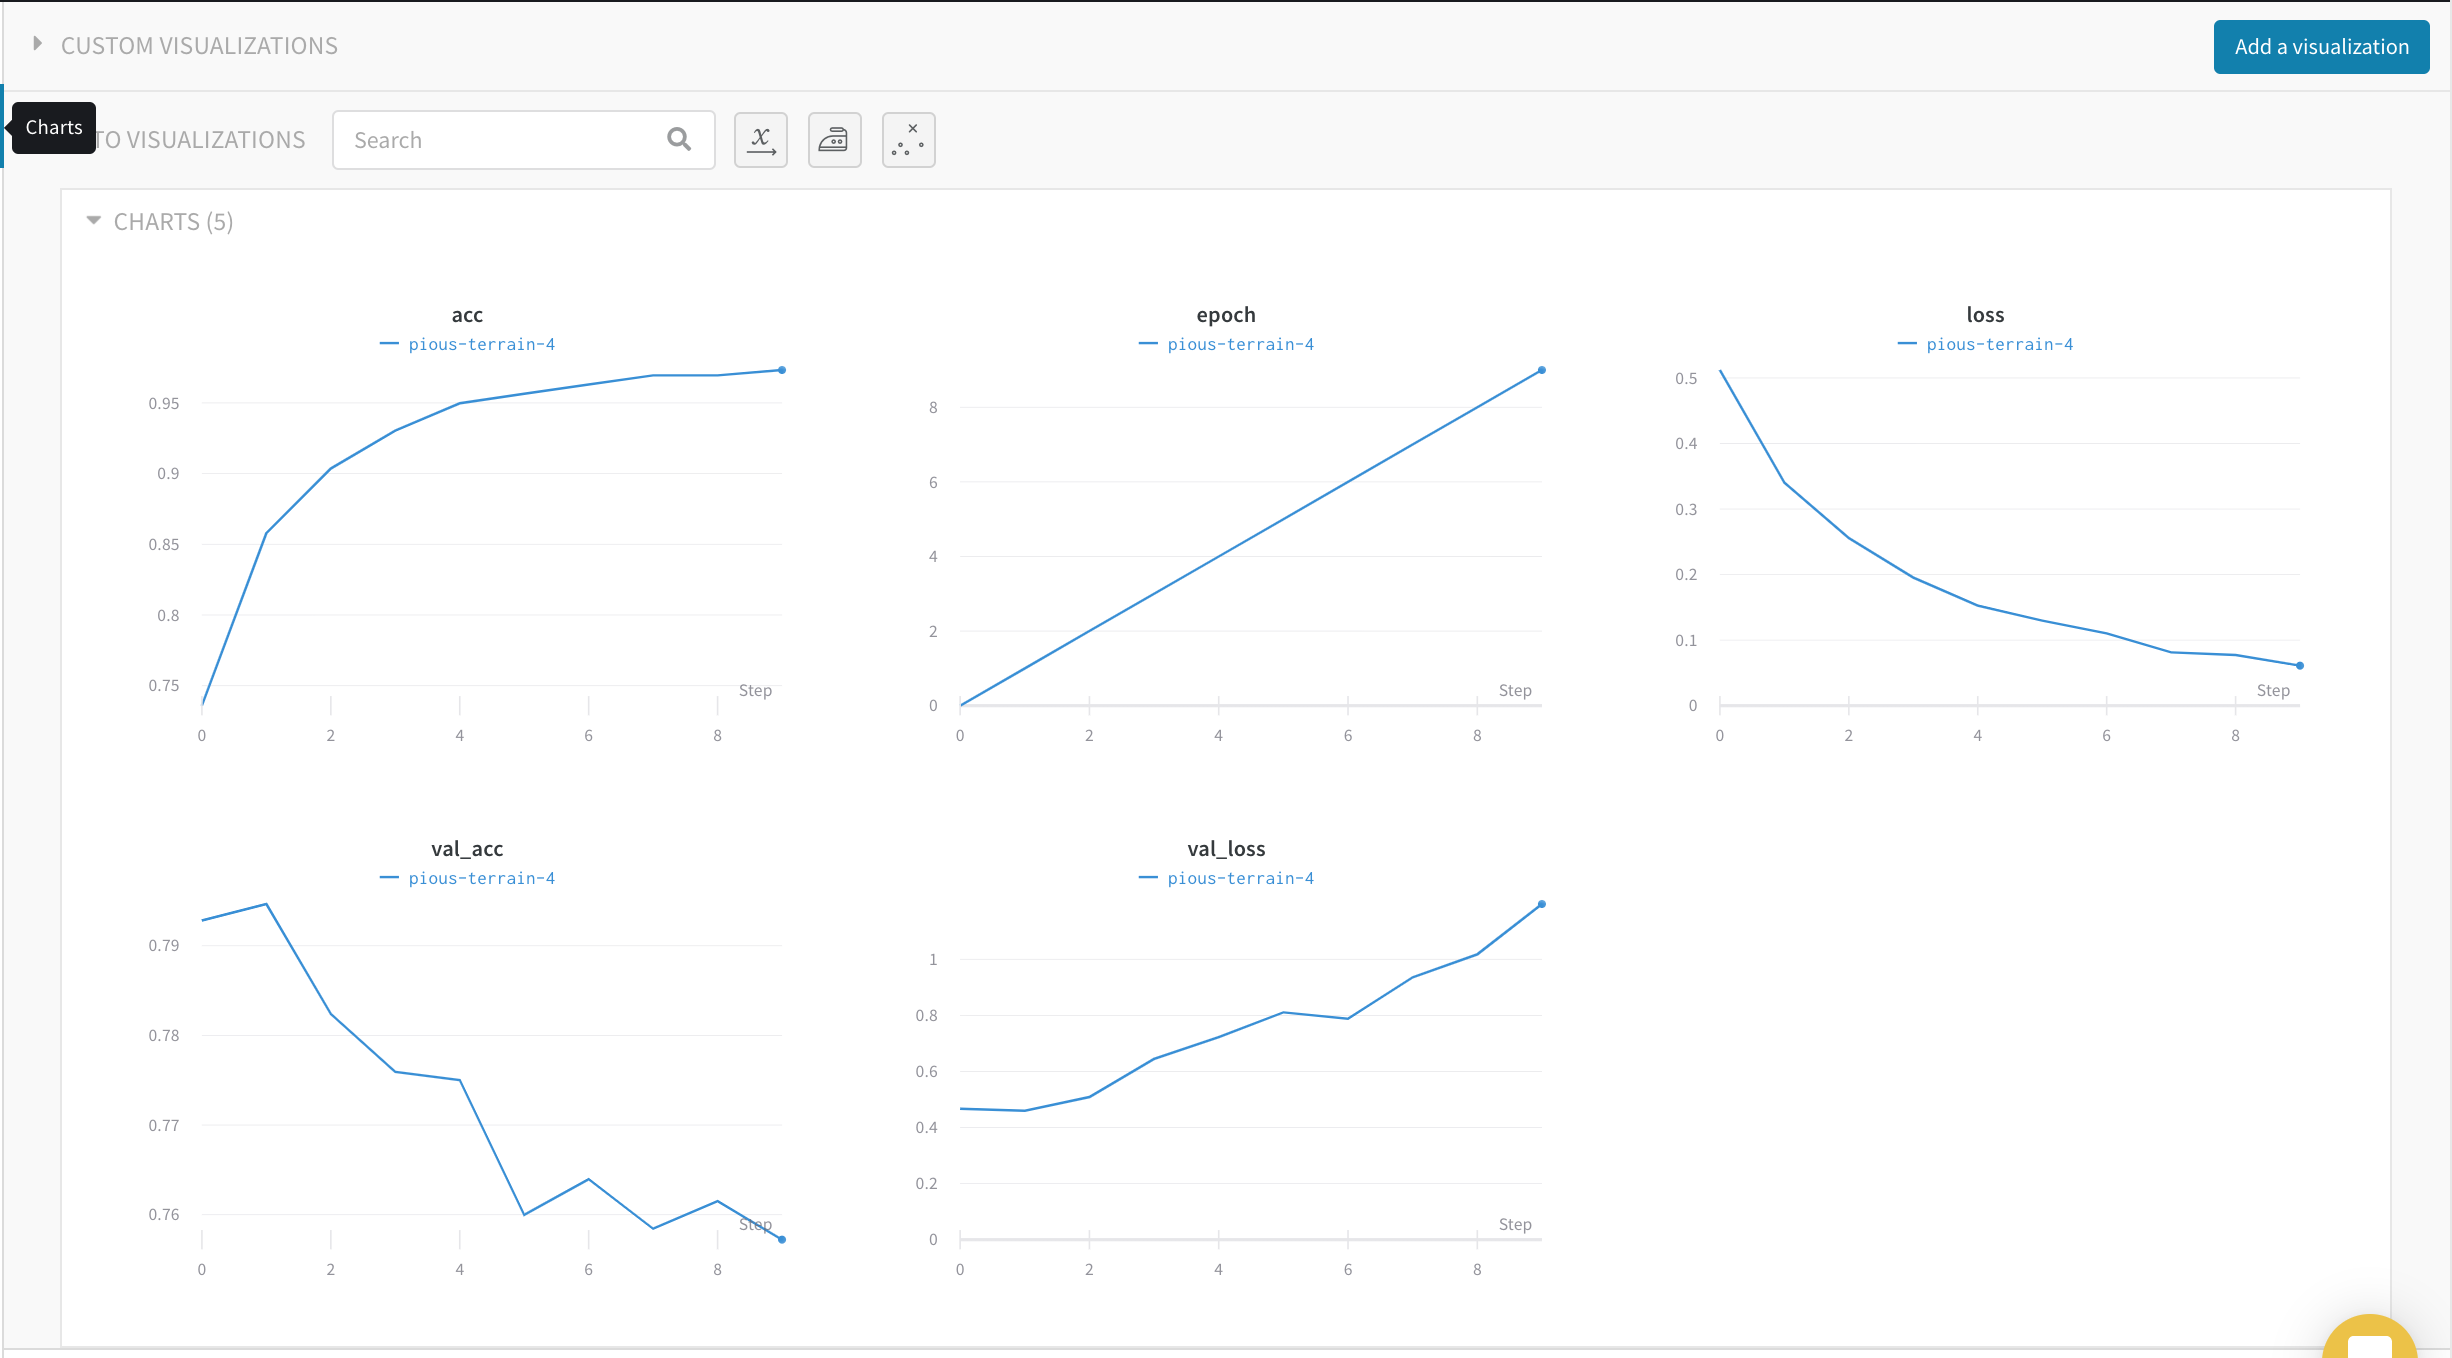

In [ ]:
from IPython.display import Image
Image('/content/Fig2.png', width=1200, height=700)

### Visualize System Metrics
The System tab on the runs page lets you visualize how resource efficient your model was. It lets you monitor the GPU, memory, CPU, disk, and network usage in one spot.